<a href="https://colab.research.google.com/github/brian8128/SchemaFuse/blob/main/examples/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# import some dependencies
import torchvision
import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(linewidth=120)

import random
from sklearn.metrics import confusion_matrix


# TODOs:
* Make a writeup about what we're doing
* Use Cases:
  * Adding one more class at the last minute. Say for example that sneaker and ankle boot were considered as one class, closed toe shoe, but we want to split them at the last minute. We only have time to label a handful of examples for this class but we have a lot of "closed toe shoe" examples.
  * Merging two customer datasets. Each customer has a "background" class and a few foreground classes. We're going to merge these two datasets to train a single model.
  * Why doesn't it work as well to just stick the same information into torches native cross entropy loss function? After all it supports a vector of labels natively which is typically used for label smoothing. In native torch The log function is computed before rather than after the sum. I conjecture that this will lead to wanting a positive probability for ALL of the labeled classes rather than just one of them. However, in this work there is one correct class label per image and we would like most of the probability assigned to that correct label, we just don't always know which it is.

# Multiple Choice Cross Entropy With Fashion MNIST

Train a network for fashion mnist. Then make the labels noisier. Instead of knowing the exact class label, we know that it's one of two. Or one of nine. See if we can get the network to work well even with this restriction.


## Standard Fashion MNIST

Train a normal fashion MNIST model as a baseline.

In [ ]:
from torch.utils.data.dataloader import default_collate


In [ ]:
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=True,
                                              transform=transforms.Compose([transforms.ToTensor()]))

test_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              train=False,
                                              transform=transforms.Compose([transforms.ToTensor()]))

In [ ]:
data_loader = torch.utils.data.DataLoader(train_set, batch_size=10, shuffle=True)
sample = next(iter(data_loader))

imgs, lbls = sample

image tensor: torch.Size([10, 1, 28, 28])
class labels: tensor([8, 4, 0, 3, 3, 9, 2, 4, 8, 1])


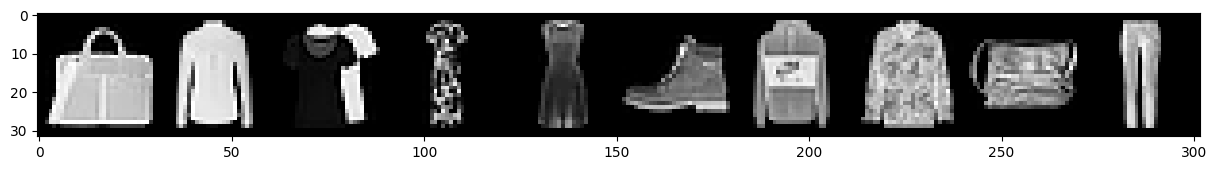

In [ ]:
# create a grid
plt.figure(figsize=(15,10))
grid = torchvision.utils.make_grid(nrow=20, tensor=imgs)
print(f"image tensor: {imgs.shape}")
print(f"class labels: {lbls}")
plt.imshow(np.transpose(grid, axes=(1,2,0)), cmap='gray');

In [ ]:
# define some helper functions
def get_item(preds, labels):
    """function that returns the accuracy of our architecture"""
    return preds.argmax(dim=1).eq(labels).sum().item()

@torch.no_grad() # turn off gradients during inference for memory effieciency
def get_all_preds(network, dataloader):
    """function to return the number of correct predictions across data set"""
    all_preds = torch.tensor([])
    model = network
    for batch in dataloader:
        images, labels = batch
        preds = model(images) # get preds
        all_preds = torch.cat((all_preds, preds), dim=0) # join along existing axis

    return all_preds


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [ ]:
# define network

class Network(nn.Module): # extend nn.Module class of nn
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))
        self.batchN1 = nn.BatchNorm2d(num_features=6)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.batchN2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t): # implements the forward method (flow of tensors)

        # hidden conv layer
        t = self.conv1(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)
        t = self.batchN1(t)

        # hidden conv layer
        t = self.conv2(t)
        t = F.max_pool2d(input=t, kernel_size=2, stride=2)
        t = F.relu(t)

        # flatten
        t = t.reshape(-1, 12*4*4)
        t = self.fc1(t)
        t = F.relu(t)
        t = self.batchN2(t)
        t = self.fc2(t)
        t = F.relu(t)

        # output
        t = self.out(t)

        return t

In [ ]:
cnn_model = Network().cuda() # init model
print(cnn_model) # print model structure

Network(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (batchN2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [ ]:
# let's also normalize the data for faster convergence

# import data
mean = 0.2859;  std = 0.3530 # calculated using standization from the MNIST itself which we skip in this blog
train_set = torchvision.datasets.FashionMNIST(root="./", download=True,
                                              transform=transforms.Compose([transforms.ToTensor(),
                                                                            transforms.Normalize(mean, std)
                                                                           ]))
data_loader = torch.utils.data.DataLoader(train_set, batch_size=100, shuffle=True, num_workers=1)

In [ ]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.2859, std=0.353)
           )

In [ ]:
optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())
# def train loop

for epoch in range(5):
    start_time = time.time()
    total_correct = 0
    total_loss = 0
    for batch in data_loader:
        imgs, lbls = batch
        imgs = imgs.cuda()
        lbls = lbls.cuda()
        preds = cnn_model(imgs) # get preds
        loss = F.cross_entropy(preds, lbls) # compute loss
        optimizer.zero_grad() # zero grads
        loss.backward() # calculates gradients
        optimizer.step() # update the weights

        total_loss += loss.item()
        total_correct += get_item(preds, lbls)
        accuracy = total_correct/len(train_set)
    end_time = time.time() - start_time
    print("Epoch no.",epoch+1 ,"|accuracy: ", round(accuracy, 3)*100,"%", "|total_loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")

Epoch no. 1 |accuracy:  82.8 % |total_loss:  278.1558710038662 | epoch_duration:  16.29 sec
Epoch no. 2 |accuracy:  87.3 % |total_loss:  206.40307915955782 | epoch_duration:  15.56 sec
Epoch no. 3 |accuracy:  88.4 % |total_loss:  187.1496308296919 | epoch_duration:  15.58 sec
Epoch no. 4 |accuracy:  88.9 % |total_loss:  179.9171510860324 | epoch_duration:  16.25 sec
Epoch no. 5 |accuracy:  89.5 % |total_loss:  169.2285431176424 | epoch_duration:  15.55 sec


In [ ]:
# get all preds
pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=train_set, num_workers=1)
all_preds= get_all_preds(network=cnn_model.cpu(), dataloader=pred_data_loader)

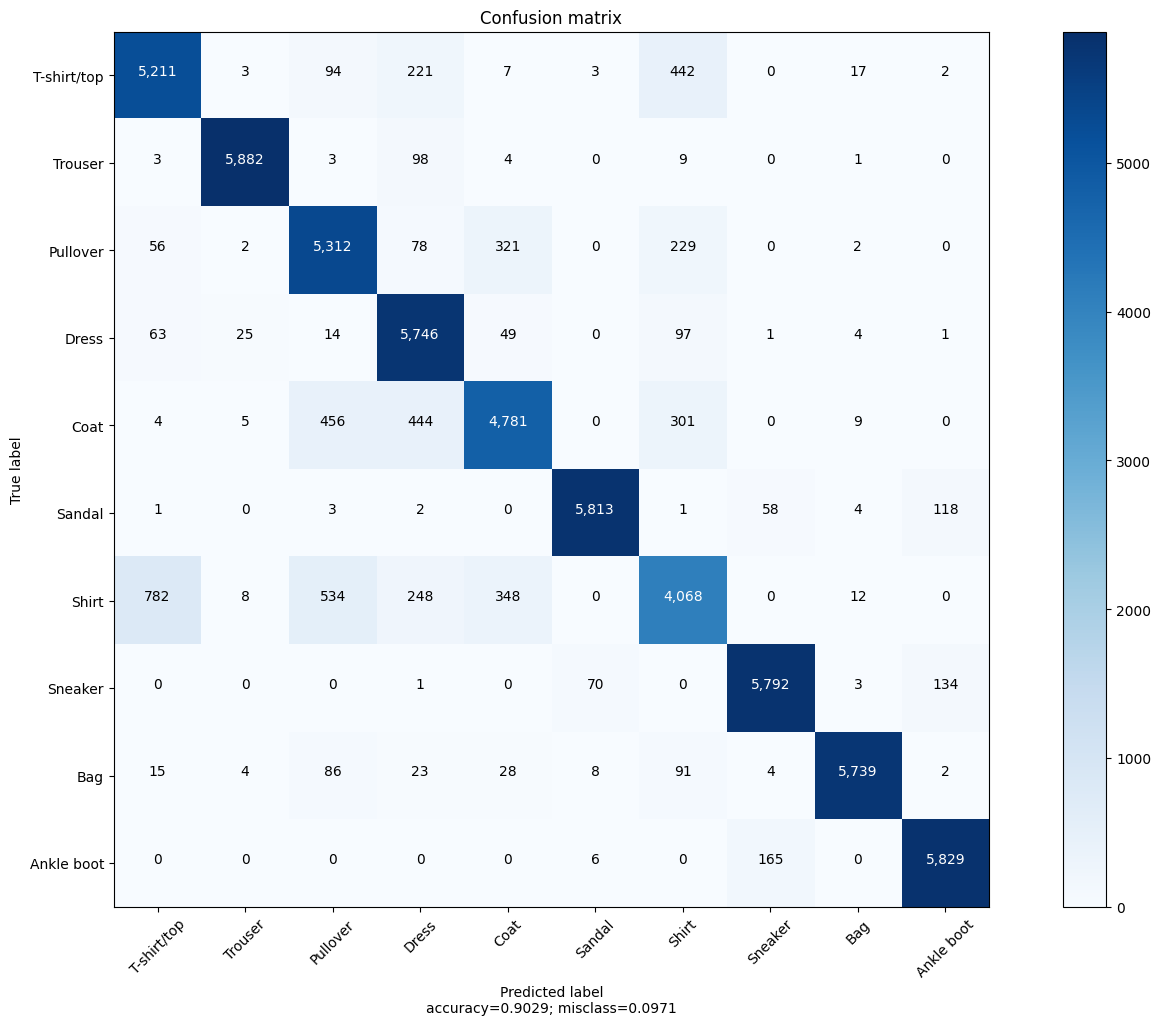

In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_true=train_set.targets, y_pred=all_preds.argmax(1)),
                      target_names=train_set.classes, normalize=False)


## Weaken the Labels

Let's pick two classes, i and j, and change 90% of the i labels into either i or j. Can we use this data to train a model that is better than the one we get if we simply discard the ambigious labels?

In [ ]:
i = 0
j = 1

frac_labeled = 0.1

In [ ]:
def multiple_choice_cross_entropy(preds, labels):
  """
  A replacement for torch.nn.functional.cross_entropy_loss where the labels can
  contain more than one possibly correct answer. These labels are combined with
  a logical OR instead of a logical AND so either answer is regarded as correct
  even if zero probability is assigned to the/an other possible correct answer.

  preds - The same as in F.cross_entropy_loss
  """
  num = -torch.log(torch.sum(torch.exp(preds) * labels, axis=1))
  denom = torch.log(torch.sum(torch.exp(preds), axis=1))
  losses = num + denom
  return torch.mean(losses)

In [ ]:
i_labels_to_make_ambiguous = (train_set.targets == i) * (torch.rand(train_set.targets.size()) < 0.9)
                             # everything annotated with i        # randomly select 90% of them
i_labels_to_make_ambiguous

tensor([False,  True,  True,  ..., False,  True, False])

In [ ]:
train_set

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.2859, std=0.353)
           )

In [ ]:
class CustomImageDataset(Dataset):
    """
    Create a custom wrapper around the dataset because we want our labels
    to be a vector instead of a single integer
    """
    # TODO: replace this with at target_transform in the normal torchvision
    # fashion MNist dataset so we don't have to do our own custom one.
    # https://pytorch.org/vision/stable/generated/torchvision.datasets.FashionMNIST.html
    #
    def __init__(self, train_set, labels):
        self.inner_train_set = train_set
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.inner_train_set[idx][0], self.labels[idx]

one_hot_labels = torch.nn.functional.one_hot(train_set.targets, num_classes=-1).to(torch.float)
one_hot_labels[:, j] += i_labels_to_make_ambiguous

train_data = CustomImageDataset(train_set, one_hot_labels)
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)

In [ ]:
def train_model(train_dataset, cross_entropy_loss_fn="native_pytorch", epochs=5):
  assert cross_entropy_loss_fn in ("native_pytorch", "multiple_choice_cel")
  if cross_entropy_loss_fn == "native_pytorch":
    cross_entropy_loss_fn = F.cross_entropy
  elif cross_entropy_loss_fn == "multiple_choice_cel":
    cross_entropy_loss_fn = multiple_choice_cross_entropy
  else:
    raise

  train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)

  cnn_model = Network().cuda() # init model
  optimizer = optim.Adam(lr=0.01, params=cnn_model.parameters())

  for epoch in range(epochs):
      start_time = time.time()
      total_correct = 0
      total_loss = 0
      for batch in train_loader:
          imgs, lbls = batch
          imgs = imgs.cuda()
          lbls = lbls.cuda()
          preds = cnn_model(imgs) # get preds
          loss = cross_entropy_loss_fn(preds, lbls) # compute loss
          optimizer.zero_grad() # zero grads
          loss.backward() # calculates gradients
          optimizer.step() # update the weights

          # TODO: Implement accuracy the same way as we do in the loss.
          # the label is A OR B, so if the model predicts either A OR B
          # then we consider that example correctly labeled.
      end_time = time.time() - start_time
      print("Epoch no.",epoch+1 ,"| epoch_duration: ", round(end_time,2),"sec")

  return cnn_model

In [ ]:
cnn_model = train_model(train_data, cross_entropy_loss_fn="multiple_choice_cel")

# get all preds
pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=train_set, num_workers=1)
all_preds= get_all_preds(network=cnn_model.cpu(), dataloader=pred_data_loader)

Epoch no. 1 | epoch_duration:  16.31 sec
Epoch no. 2 | epoch_duration:  20.63 sec
Epoch no. 3 | epoch_duration:  20.94 sec
Epoch no. 4 | epoch_duration:  14.4 sec
Epoch no. 5 | epoch_duration:  14.56 sec


In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_true=train_set.targets, y_pred=all_preds.argmax(1)), target_names=train_set.classes, normalize=False)


# Use Case: Merging Datasets

Suppose that you have two customer datasets from different customers with similar goals. They both want to identify certain objects in the images and they both have a "background" class to cover everything they don't care about identifying.

Customer 1 has annotated 'T-shirt/top', 'Trouser', 'Pullover', and 'Dress' and has labeled everything else as 'background'.

Customer 2 has annotated 'Pullover', 'Dress', 'Coat', and 'Sandal' and has labeled everything else as background.

We want to train a model that can predict all 6 classes, 'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', and 'Sandal', as well as a 'background' class. However, we will have to be a bit clever with training. For the non-background images we can train as usual. However, Customer 1's background images include the 'Coat' and 'Sandal' classes. Therefore we will train the model that these images are 'Background' OR 'Coat' OR 'Sandal'. Similarily we will train the model that Customer 2's background images are 'Background' OR 'T-shirt/top' OR 'Trouser'.

As we know from probability theory P(A OR B) = P(A) + P(B) - P(A AND B). In our model class labels are non-overlapping so P(A AND B) = 0.

Let's give Customer 1 80% of the data to simulate some real world messiness.

We'll train 3 models and compare the results. Customer 1's model, Customer 2's model, and the joint model using this logical OR style training.

## Create Datasets



In [ ]:
from torch.utils.data import random_split


In [ ]:
random_split(train_set, lengths=[0.8, 0.2])

In [ ]:
classes_c1 = ["Background"] + train_set.classes[:4]
print("Customer 1 class labels: " + str(classes_c1))

classes_c2 = ["Background"] + train_set.classes[2:6]
print("Customer 2 class labels: " + str(classes_c2))

# By default the train test split does an 80/20 split giving us our "messy" unequal distribution

train_data_c1, train_data_c2, train_targets_c1, train_targets_c2 = train_test_split(train_set.data, train_set.targets)

# Customer 1 has classes 0-4 as the labeled classes and classes 4-10 are background
# We're going to make background class 0
def make_c1_targets(targets):
  """
  Take as inputs the targets from normal fashion mnist and create targets
  labeled the way customer 1 labels them
  """
  targets_c1 = targets.clone()
  targets_c1 += 1
  targets_c1[targets_c1 > 4] = 0
  return targets_c1

# Customer 2 has classes 2-6 as their labeled classes with classes, 0, 1, and 6+ background
# They label background as class 0 and classes 2-6 as classes 1-5
def make_c2_targets(targets):
  """
  Take as inputs the targets from normal fashion mnist and create targets
  labeled the way customer 1 labels them
  """
  targets_c2 = targets.clone()
  targets_c2 -= 1
  targets_c2[(targets_c2 < 0) | (4 < targets_c2)] = 0
  return targets_c2

train_targets_c1_processed = make_c1_targets(train_targets_c1)
train_targets_c2_processed = make_c2_targets(train_targets_c2)

# For simplicity, customer 1 and customer 2 will have the same test data,
# but with their own labels.

test_data_c1 = test_data_c2 = test_set.data
test_targets_c1 = test_targets_c2 = test_set.targets

test_targets_c1_processed = make_c1_targets(test_targets_c1)
test_targets_c2_processed = make_c2_targets(test_targets_c2)

In [ ]:
train_targets_c1_one_hot = torch.nn.functional.one_hot(test_targets_c1_processed, num_classes=-1)
train_targets_c2_one_hot = torch.nn.functional.one_hot(test_targets_c1_processed, num_classes=-1)

train_dataset_c1 = CustomImageDataset(train_data_c1, train_targets_c1_one_hot.to(torch.float))
train_dataset_c2 = CustomImageDataset(train_data_c2, train_targets_c2_one_hot.to(torch.float))

## Customer 1 Model

In [ ]:
cnn_model = train_model(train_dataset_c1, cross_entropy_loss_fn="multiple_choice_cel")

# get all preds
c1_pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=train_set, num_workers=1)
all_preds= get_all_preds(network=cnn_model.cpu(), dataloader=pred_data_loader)

In [ ]:
len(data_a), len(data_b)

In [ ]:
train_set.data

## Weakest Possible Labels: One Class It's Not

Let's train the model on the weakest possible labels. Instead of telling the model one class that is correct let's tell the model one class that's not correct.

In [ ]:
random_labels = torch.randint(low=0, high=9, size=train_set.targets.size())
random_labels += random_labels >= train_set.targets
# Now we know that random labels are not equal to train_set.targets but otherwise
# uniformly distributed.

In [ ]:
one_hot_labels = (1 - torch.nn.functional.one_hot(random_labels, num_classes=-1)).cuda()
one_hot_labels

In [ ]:
train_data = CustomImageDataset(train_set, one_hot_labels)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)

cnn_model = Network().cuda() # init model

optimizer = optim.Adam(lr=0.001, params=cnn_model.parameters())

for epoch in range(5):
    start_time = time.time()
    total_correct = 0
    total_loss = 0
    for batch in train_loader:
        imgs, lbls = batch
        imgs = imgs.cuda()
        lbls = lbls.cuda()
        preds = cnn_model(imgs) # get preds
        loss = multiple_choice_cross_entropy(preds, lbls) # compute loss
        # loss = F.cross_entropy(preds, torch.tensor(lbls, dtype=torch.float))
        optimizer.zero_grad() # zero grads
        loss.backward() # calculates gradients
        optimizer.step() # update the weights

        total_loss += loss.item()
        # total_correct += get_item(preds, lbls)
        # accuracy = total_correct/len(train_set)
    end_time = time.time() - start_time
    # print("Epoch no.",epoch+1 ,"|accuracy: ", round(accuracy, 3)*100,"%", "|total_loss: ", total_loss, "| epoch_duration: ", round(end_time,2),"sec")
    print(f"Epoch no.{epoch+1}|total_loss: {total_loss}|epoch_duration: {round(end_time,2)}sec")

In [ ]:
# get all preds
pred_data_loader = torch.utils.data.DataLoader(batch_size=10000, dataset=train_set, num_workers=1)
all_preds= get_all_preds(network=cnn_model.cpu(), dataloader=pred_data_loader)

In [ ]:
plot_confusion_matrix(cm=confusion_matrix(y_true=train_set.targets, y_pred=all_preds.argmax(1)), target_names=train_set.classes, normalize=False)
